In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
print(os.listdir("../input"))

['database.sqlite', 'hashes.txt', 'Reviews.csv']


In [2]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style('whitegrid')

In [3]:
data = pd.read_csv('../input/Reviews.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [6]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
data = data.drop(['ProfileName', 'Time'], axis=1) # definitely dont need this

In [8]:
data['Helpfulness'] = data['HelpfulnessNumerator'] / (data['HelpfulnessNumerator'] + data['HelpfulnessDenominator'])
data['Helpfulness'].fillna(0, inplace=True)

In [9]:
data = data.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 7 columns):
Id             568454 non-null int64
ProductId      568454 non-null object
UserId         568454 non-null object
Score          568454 non-null int64
Summary        568427 non-null object
Text           568454 non-null object
Helpfulness    568454 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 30.4+ MB


In [10]:
# for item based filtering
item_based = data.drop(['UserId'], axis=1)
item_based.head()

,Id,ProductId,Score,Summary,Text,Helpfulness
0,1,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,0.5
1,2,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...,0.5
3,4,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...,0.5
4,5,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...,0.0


## Preprocessing

In [11]:
item_based['Remark'] = item_based['Summary'] + ' ' + item_based['Text']
item_based.drop(['Summary', 'Text'], axis=1, inplace=True)

In [12]:
item_based.head()

,Id,ProductId,Score,Helpfulness,Remark
0,1,B001E4KFG0,5,0.5,Good Quality Dog Food I have bought several of...
1,2,B00813GRG4,1,0.0,Not as Advertised Product arrived labeled as J...
2,3,B000LQOCH0,4,0.5,"""Delight"" says it all This is a confection tha..."
3,4,B000UA0QIQ,2,0.5,Cough Medicine If you are looking for the secr...
4,5,B006K2ZZ7K,5,0.0,Great taffy Great taffy at a great price. The...


1. Converting the `Remark` feature into a sentiment polarity. Due to the diversity of words and context observed in the column. Too much sparsity may not give good results.

In [13]:
from textblob import TextBlob 
import swifter

In [14]:
def to_sentiment(text):
    sen = TextBlob(text).sentiment.polarity
    return sen

In [15]:
item_based['Remark'].fillna(' ', inplace=True)

In [16]:
item_based['Sentiment'] = item_based['Remark'].swifter.apply(to_sentiment)

Pandas Apply:  96%|█████████▋| 548240/568454 [12:21<00:33, 607.81it/s]

In [17]:
item_based.drop(['Remark'], axis=1, inplace=True)

In [18]:
item_based.describe()

,Id,Score,Helpfulness,Sentiment
count,568454.000000,568454.000000,568454.000000,568454.000000
mean,284227.500000,4.183199,0.212997,0.266962
std,164098.679298,1.310436,0.234900,0.230729
min,1.000000,1.000000,0.000000,-1.000000
25%,142114.250000,4.000000,0.000000,0.129271
50%,284227.500000,5.000000,0.000000,0.261558
75%,426340.750000,5.000000,0.500000,0.406061
max,568454.000000,5.000000,0.750000,1.000000


In [19]:
item_based.to_csv('item_based.csv')

feature selection done. Let's explore our features and fine tune it

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


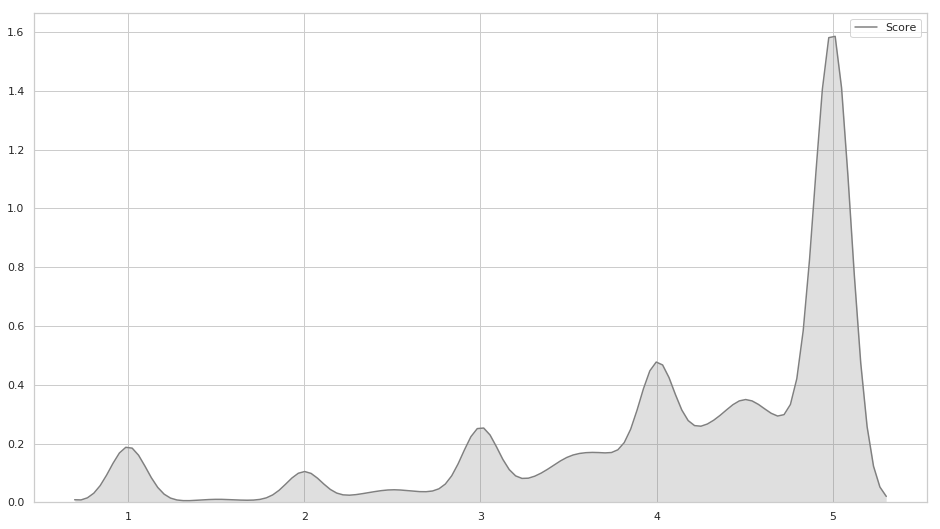

In [20]:
plt.figure(figsize=(16,9))
sns.kdeplot(item_based.groupby(['ProductId'])['Score'].mean(), shade=True, color='grey')

In [21]:
unreliability = item_based.groupby(['ProductId'])['Score'].std(ddof=-1)

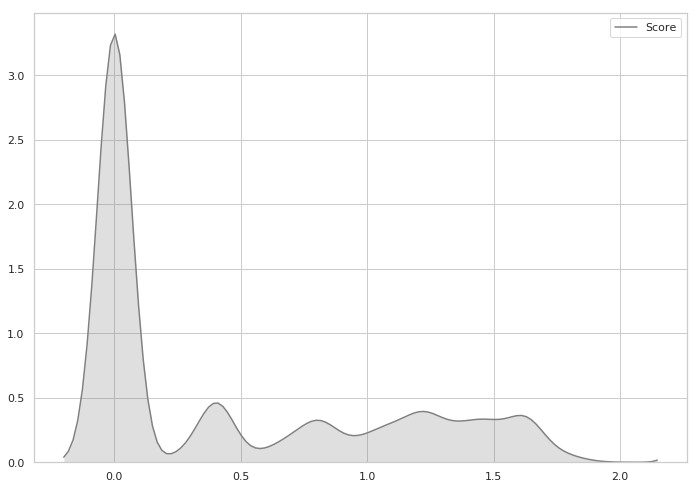

In [22]:
sns.kdeplot(unreliability, shade=True, color='grey')

Final list of features

In [23]:
product_rating = item_based.groupby('ProductId')['Score'].mean()
product_helpful = item_based.groupby('ProductId')['Helpfulness'].mean()
product_sentiment = item_based.groupby('ProductId')['Sentiment'].mean()
product_rating_count = item_based.groupby('ProductId')['Score'].count()
products = item_based.ProductId.unique()

In [24]:
data_model = pd.DataFrame({
    'Score': product_rating[products],
    'Count': product_rating_count[products],
    'Unreliability': unreliability[products],
    'Sentiment': product_sentiment[products],
    'Helpfulness': product_helpful[products]
})
data_model.head()

,Score,Count,Unreliability,Sentiment,Helpfulness
ProductId,,,,,
B001E4KFG0,5.00,1,0.000000,0.485714,0.5
B00813GRG4,1.00,1,0.000000,-0.033333,0.0
B000LQOCH0,4.00,1,0.000000,0.133571,0.5
B000UA0QIQ,2.00,1,0.000000,0.166667,0.5
B006K2ZZ7K,4.75,4,0.387298,0.424167,0.0


In [25]:
data_model.describe()

,Score,Count,Unreliability,Sentiment,Helpfulness
count,74258.000000,74258.000000,74258.000000,74258.000000,74258.000000
mean,4.166189,7.655121,0.459850,0.268592,0.199298
std,1.070182,26.453485,0.594568,0.188121,0.187791
min,1.000000,1.000000,0.000000,-1.000000,0.000000
25%,3.783784,1.000000,0.000000,0.168368,0.000000
50%,4.500000,2.000000,0.000000,0.270302,0.181250
75%,5.000000,5.000000,1.000000,0.369520,0.342073
max,5.000000,913.000000,1.946657,1.000000,0.500000


In [26]:
def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [27]:
data_model = normalize(data_model)
data_model.head()

,Score,Count,Unreliability,Sentiment,Helpfulness
ProductId,,,,,
B001E4KFG0,10.000,0.000000,0.000000,7.428571,10.0
B00813GRG4,0.000,0.000000,0.000000,4.833333,0.0
B000LQOCH0,7.500,0.000000,0.000000,5.667857,10.0
B000UA0QIQ,2.500,0.000000,0.000000,5.833333,10.0
B006K2ZZ7K,9.375,0.032895,1.989556,7.120833,0.0


## Modelling the recommender

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
engine = KNeighborsClassifier(n_neighbors=20)

data_points = data_model.values
labels = data_model.index.values

print('Data: ', data_points)
print('Labels: ', labels)

engine.fit(data_points, labels)

Data:  [[10.          0.          0.          7.42857143 10.        ]
 [ 0.          0.          0.          4.83333333  0.        ]
 [ 7.5         0.          0.          5.66785714 10.        ]
 ...
 [ 2.5         0.          0.          3.57142857  0.        ]
 [10.          0.01096491  0.          6.7453125  10.        ]
 [10.          0.          0.          6.58653846  0.        ]]
Labels:  ['B001E4KFG0' 'B00813GRG4' 'B000LQOCH0' ... 'B003S1WTCU' 'B004I613EE'
 'B001LR2CU2']


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [30]:
product_id = 'B0098WV8F2'
product_data = data_model.loc[product_id].values

recommended_products = engine.kneighbors(X=[product_data], n_neighbors=20, return_distance=False)

products_list = []
for prod in recommended_products:
    products_list.append(data_model.iloc[prod].index)
    
print('Recommended Products: ')
print(products_list)

Recommended Products: 
[Index(['B0098WV8F2', 'B00004CXX9', 'B00004RYGX', 'B00004CI84', 'B0001ES9FI',
       'B005GX00BK', 'B005GXHKSG', 'B005GX8MMO', 'B005GRCWDU', 'B005GTWCTM',
       'B001E5E0D8', 'B003CK0XC0', 'B000CQC04Q', 'B000CQBZOW', 'B000CQG87Q',
       'B000CQG89Y', 'B000CQC050', 'B000CQIDHO', 'B0012BUR8Q', 'B000CQID2Y'],
      dtype='object', name='ProductId')]


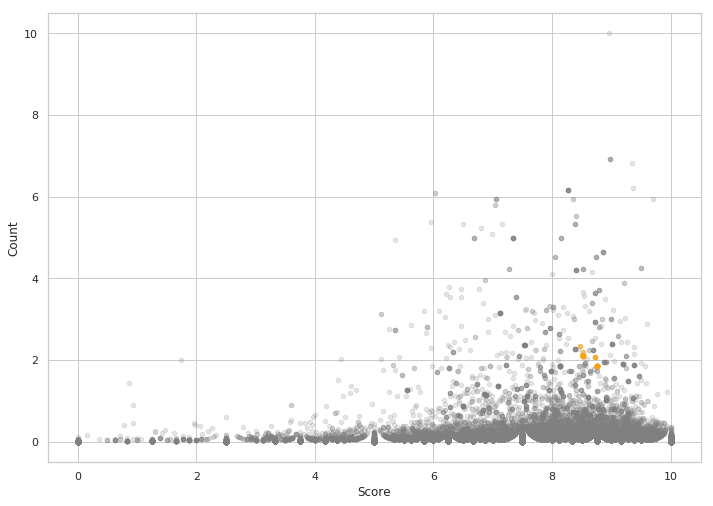

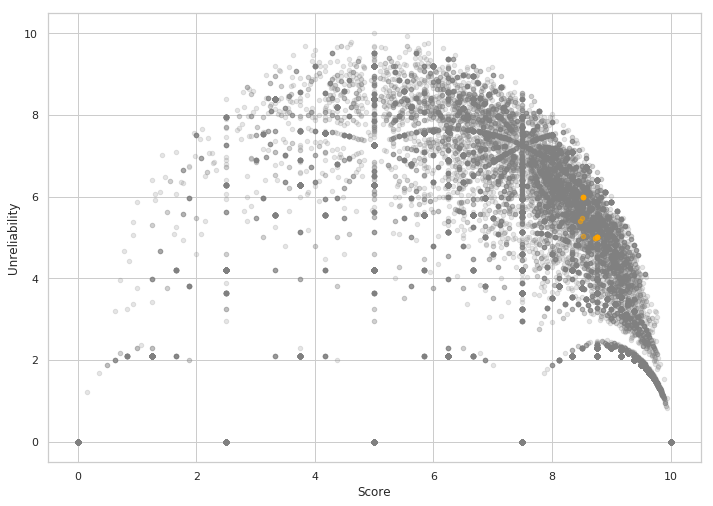

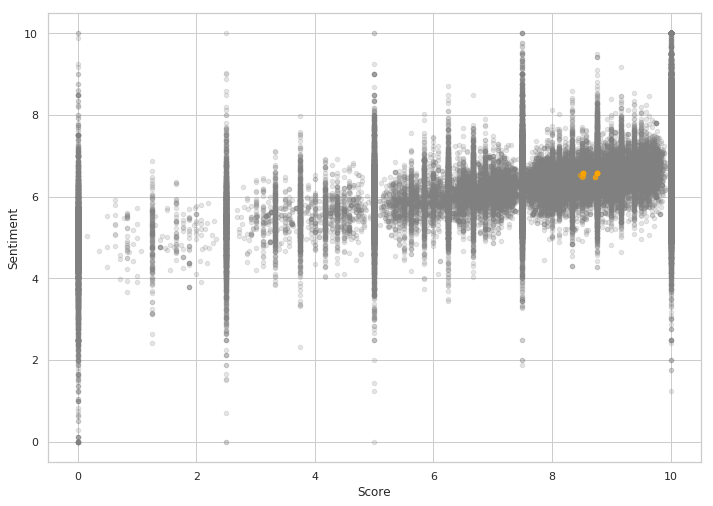

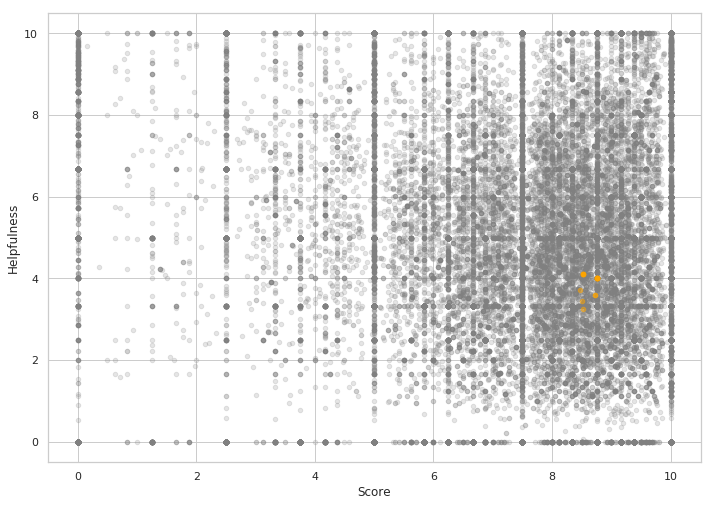

In [31]:
ax = data_model.plot(kind='scatter', x='Score', y='Count', color='grey', alpha=0.20)
data_model.iloc[recommended_products[0]].plot(kind='scatter', x='Score', y='Count', color='orange', alpha=0.50, ax=ax)

ax2 = data_model.plot(kind='scatter', x='Score', y='Unreliability', color='grey', alpha=0.20)
data_model.iloc[recommended_products[0]].plot(kind='scatter', x='Score', y='Unreliability', color='orange', alpha=0.50, ax=ax2)

ax2 = data_model.plot(kind='scatter', x='Score', y='Sentiment', color='grey', alpha=0.20)
data_model.iloc[recommended_products[0]].plot(kind='scatter', x='Score', y='Sentiment', color='orange', alpha=0.50, ax=ax2)

ax2 = data_model.plot(kind='scatter', x='Score', y='Helpfulness', color='grey', alpha=0.20)
data_model.iloc[recommended_products[0]].plot(kind='scatter', x='Score', y='Helpfulness', color='orange', alpha=0.50, ax=ax2)